# Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from importlib import reload
import scandelay_FTIR as sd
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
#from common import plotting

In [23]:
pwd

'C:\\Users\\mnopl\\Desktop\\Software\\mnOPSuite\\PRISM\\python'

# New normalization method

In [710]:
interp_kwargs=dict(bounds_error=False,
                   fill_value=0,
                   kind='cubic')    

def normalize_spectra2(spectra, spectra_ref, phase_slope=0,
                      apply_envelope=True, expand_envelope=1,
                      reference_phase=False,f0=None):
    # `Spectra` is expected to be a set of stacked row vectors in groups of five,
    # each group is indexed by row as:
    # 0: frequencies
    # 1: spectrum amplitude
    # 2: spectrum phase
    # 3: spectrum envelope
    # 4: envelope parameters
    # Same for reference spectra

    # We need to apply envelopes from reference to analyte spectra!

    # Presumably we can now refresh any dX
    #global dX
    #dX = None #Keep dX through duration of experiment

    spectra = np.array(spectra)
    spectra_ref = np.array(spectra_ref)

    Nrows = 5
    if apply_envelope:
        assert len(spectra)==len(spectra_ref),\
            "Applying envelope requires same number of accumulations for both analyte and reference"

    assert len(spectra) % Nrows == 0, 'Input spectra must come as stacked groups of %i row vectors'%Nrows
    assert len(spectra_ref) % Nrows == 0, 'Input spectra must come as stacked groups of %i row vectors'%Nrows

    s_accumulated = []
    s_accumulated_abs = 0
    s_accumulated_ref = []
    s_accumulated_abs_ref = 0
    Nspectra = np.max( (len(spectra) // Nrows, 1) )

    # Establish some mutual frequency axis
    if f0 is None:
        f0_given=False
        all_fs = np.append([], [spectra[Nrows * i] for i in range(Nspectra)] \
                               + [spectra_ref[Nrows * i] for i in range(Nspectra)] )
        Nf = len(all_fs)//(2*Nspectra)
        f0 = np.linspace(np.min(all_fs),
                         np.max(all_fs),
                         Nf)
    else: f0_given=True

    for i in range(Nspectra):

        ## Analyte spectrum components
        f = spectra[Nrows * i]
        sabs = spectra[Nrows * i + 1]
        sphase = spectra[Nrows * i + 2]
        s = sabs * np.exp(1j * sphase)

        # In case we have invalid entries (zeros), remove them
        where_valid = np.isfinite(f) * (f > 0)
        f = f[where_valid]
        s = s[where_valid]
        s = interp1d(f, s, **sd.interp_kwargs)(f0)

        ## Reference spectrum components
        f_ref = spectra_ref[Nrows * i]
        sabs_ref = spectra_ref[Nrows * i + 1]
        sphase_ref = spectra_ref[Nrows * i + 2]
        s_ref = sabs_ref * np.exp(1j * sphase_ref)

        # In case we have invalid entries (zeros), remove them
        where_valid = np.isfinite(f_ref) * (f_ref > 0)
        f_ref = f_ref[where_valid]
        s_ref = s_ref[where_valid]

        s_ref = interp1d(f_ref, s_ref,  **sd.interp_kwargs)(f0)

        if apply_envelope:
            env_params = spectra_ref[Nrows * i + 4][:3]
            env = sd.spectral_envelope(f0, *env_params,
                                    expand_envelope=expand_envelope)
            env_norm = env/env.max() # normalize the envelope to unity
            s_ref = s_ref * env_norm
            s = s * env_norm

        s_accumulated.append(s)
        s_accumulated_abs += np.abs(s)
        s_accumulated_ref.append(s_ref)
        s_accumulated_abs_ref += np.abs(s_ref)
        
    s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref
    s_norm = np.sum(s_accumulated,axis=0)/np.sum(s_accumulated_ref,axis=0)
    s_norm_phase = np.angle(s_norm)

    # having divided by a reference possibly with zeros, remove those entries
    if not f0_given:
        where_valid = (s_accumulated_abs_ref > s_accumulated_abs_ref.max()/20)
        s_norm_abs=s_norm_abs[where_valid]
        f0 = f0[where_valid]
        s_norm_phase = s_norm_phase[where_valid]
        s_accumulated = [s_accum[where_valid] for s_accum in s_accumulated]
        s_accumulated_ref = [s_accum[where_valid] for s_accum in s_accumulated_ref]

    return f0, s_norm_abs, s_norm_phase, s_accumulated, s_accumulated_ref

In [250]:
def realigned(s,p):
    
    return np.exp(1j*f0*p)*s

def summed_spectrum0(spectra):
    
    stot = 0
    for s in spectra:
        stot = stot+np.abs(s)
        
    return stot

def summed_spectrum(ps,spectra):
    
    stot=0
    for i,p in enumerate(ps):
        stot = stot + realigned(spectra[i],p)
    
    return stot

def level_phase(s,order=1):
    
    p=np.unwrap(np.angle(s))
    m = np.polyfit(x=f0,y=p,deg=order)
    #m[-1]=0 #no overall phase offsets
    p -= np.polyval(m,f0)
    
    return np.abs(s)*np.exp(1j*p)

## BB 100% line spectrum

In [526]:
sample_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1.txt')
sample_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1_BB.txt')
ref_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2.txt')
ref_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2_BB.txt')

In [527]:
sample_spectra.shape

(180, 4095)

/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: overflow encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: invalid value encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:467: RuntimeWarning: invalid value encountered in true_divide
  s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref


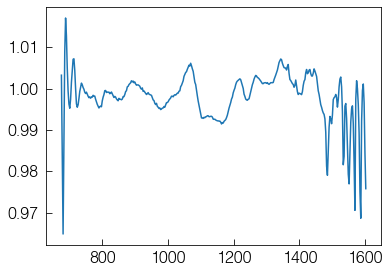

In [528]:
f0, s_norm_abs, s_norm_phase = sd.normalize_spectra(sample_spectra,sample_BB_spectra)
plt.plot(f0,s_norm_abs)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


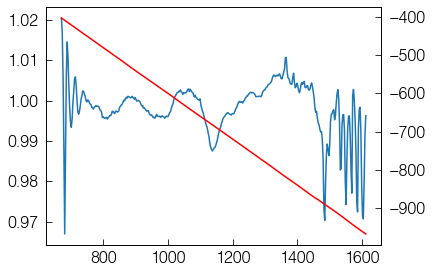

In [529]:
f0, s_norm_abs, s_norm_phase, s_accumulated, s_accumulated_ref = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=2)

plt.plot(f0,s_norm_abs)
plt.twinx()
plt.plot(f0,np.unwrap(-.6*f0+s_norm_phase),color='r')

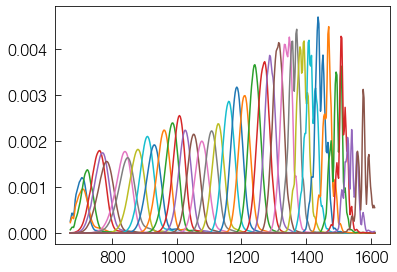

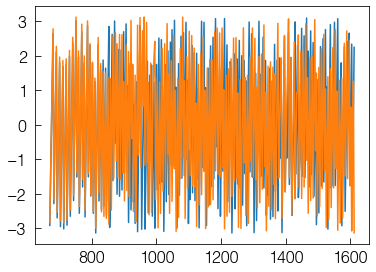

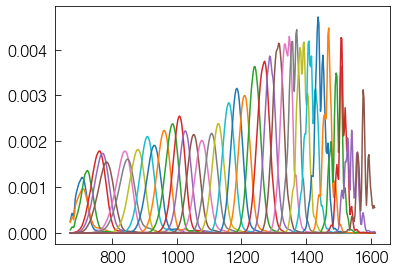

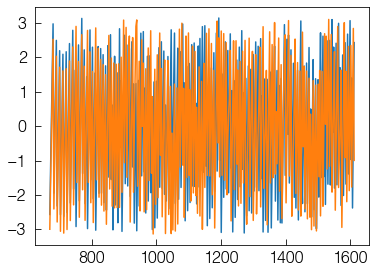

In [530]:
for s in s_accumulated_ref:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated_ref[:2]:
    plt.plot(f0,np.angle(s))

plt.figure()
for s in s_accumulated:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated[:2]:
    plt.plot(f0,np.angle(s))

### Re-align phase

In [531]:
to_minimize1 = lambda ps,spectra: 1/np.real(summed_spectrum(ps,spectra))**2
to_minimize2 = lambda ps,spectra: 1/np.abs(summed_spectrum(ps,spectra))
to_minimize3 = lambda ps,spectra,spectrum0: np.abs((np.abs(summed_spectrum(ps,spectra))-spectrum0))**.5
def to_minimize4(ps,spectra,spectrum0,exp=1):
    
    spectrum = summed_spectrum(ps,spectra)
    delta = np.abs(np.abs(spectrum)-spectrum0)**exp
    pvariation = np.unwrap(np.angle(level_phase(spectrum,2)))
    #pvariation=np.unwrap(np.angle(spectrum))
    #pvariation=np.diff(pvariation)
    penalty = np.sqrt(np.sum(np.diff(pvariation)**2))
    
    return delta*penalty**1

#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1/2 #Somehow a medium exponent converges fastest

spectra = s_accumulated_ref
stot_ref0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)

spectra = s_accumulated
stot0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

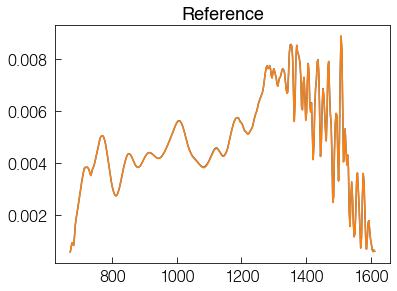

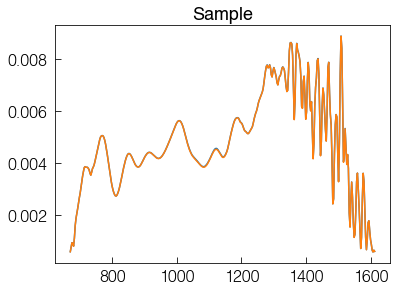

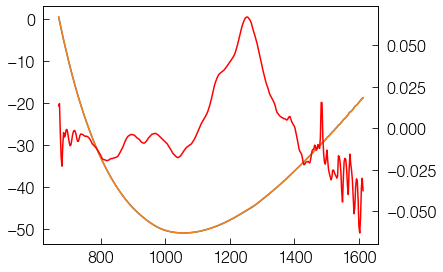

In [532]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

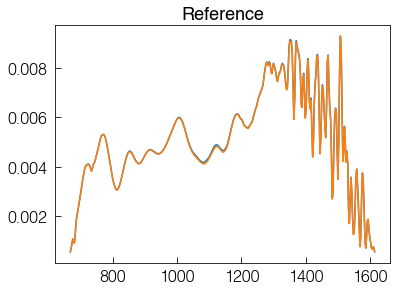

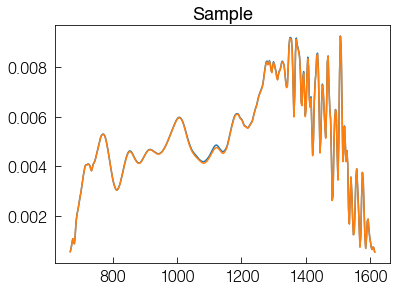

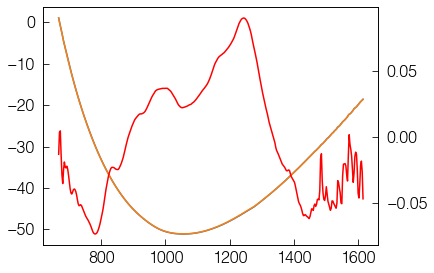

In [286]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

## SiO2 spectrum

In [533]:
sample_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm.txt')
sample_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm_BB.txt')
ref_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1.txt')
ref_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1_BB.txt')

In [534]:
sample_spectra.shape

(50, 4095)

/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: overflow encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: invalid value encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:467: RuntimeWarning: invalid value encountered in true_divide
  s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref


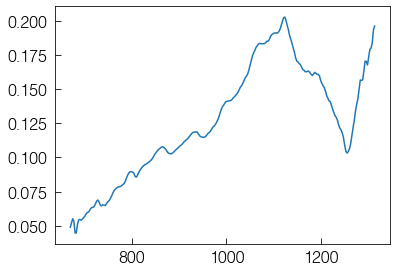

In [535]:
f0, s_norm_abs, s_norm_phase = sd.normalize_spectra(sample_spectra,sample_BB_spectra)
plt.plot(f0,s_norm_abs)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


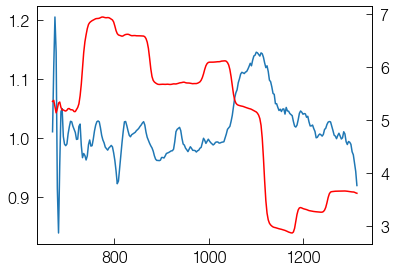

In [536]:
expand_envelope=1
f0, s_norm_abs, s_norm_phase, s_accumulated, _ = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=expand_envelope)
f0, s_norm_abs_ref, s_norm_phase_ref, s_accumulated_ref, _ = normalize_spectra2(ref_spectra,
                                                                      ref_BB_spectra,
                                                                      expand_envelope=expand_envelope,
                                                                               f0=f0)

plt.plot(f0,s_norm_abs/s_norm_abs_ref)
plt.twinx()
plt.plot(f0,np.unwrap(s_norm_phase-s_norm_phase_ref),color='r')

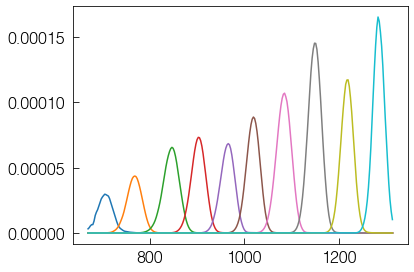

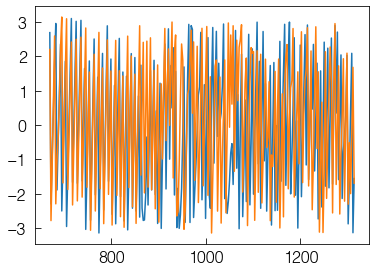

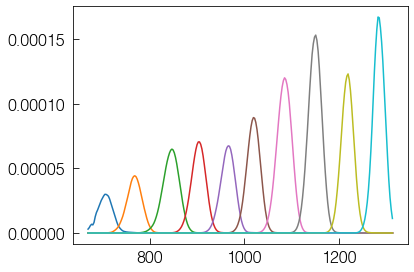

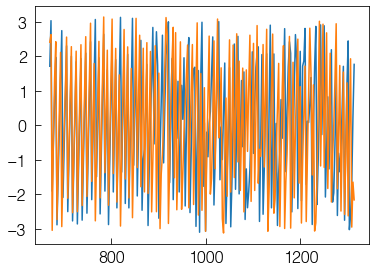

In [537]:
for s in s_accumulated_ref:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated_ref[:2]:
    plt.plot(f0,np.angle(s))

plt.figure()
for s in s_accumulated:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated[:2]:
    plt.plot(f0,np.angle(s))

### Re-align phase

In [538]:
to_minimize1 = lambda ps,spectra: 1/np.real(summed_spectrum(ps,spectra))**2
to_minimize2 = lambda ps,spectra: 1/np.abs(summed_spectrum(ps,spectra))
to_minimize3 = lambda ps,spectra,spectrum0: np.abs((np.abs(summed_spectrum(ps,spectra))-spectrum0))**.5
def to_minimize4(ps,spectra,spectrum0,exp=1):
    
    spectrum = summed_spectrum(ps,spectra)
    delta = np.abs(np.abs(spectrum)-spectrum0)**exp
    pvariation = np.unwrap(np.angle(level_phase(spectrum,2)))
    pvariation=np.diff(pvariation)
    penalty = np.sqrt(np.sum(np.diff(pvariation)**2))
    
    return delta*penalty**1

#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1/2

spectra = s_accumulated_ref
stot_ref0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)

spectra = s_accumulated
stot0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

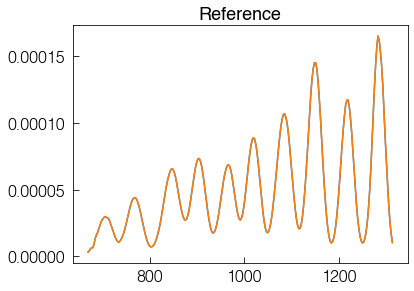

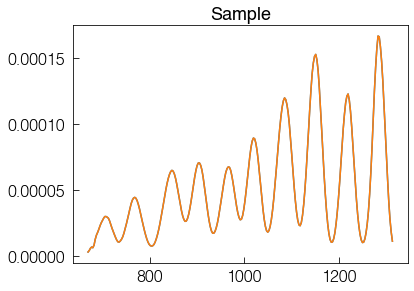

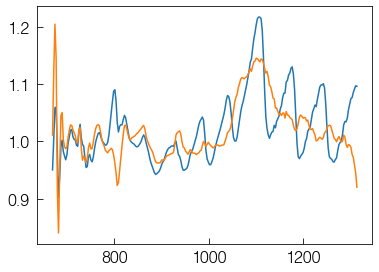

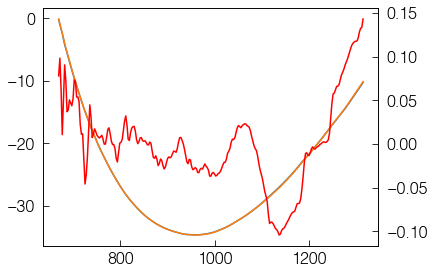

In [539]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.abs(snorm))
plt.plot(f0,s_norm_abs/s_norm_abs_ref)

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

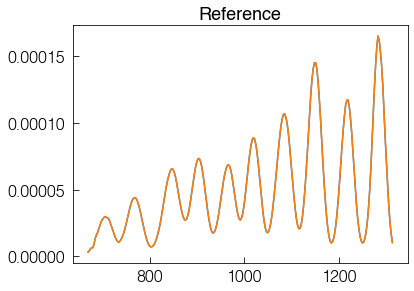

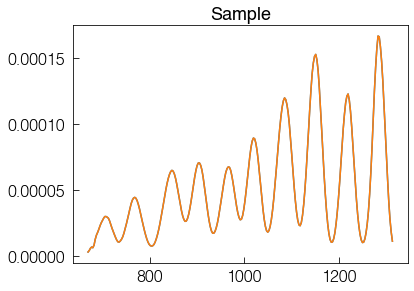

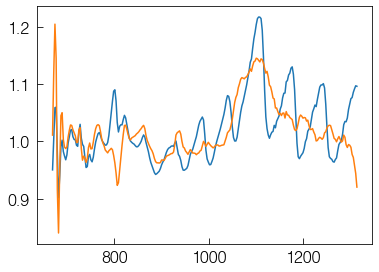

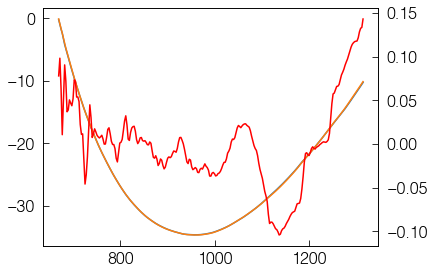

In [503]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.abs(snorm))
plt.plot(f0,s_norm_abs/s_norm_abs_ref)

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

## TiO2 spectrum

In [644]:
# Reference was some crummy piece of metal contact on the surface
sample_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra.txt')
sample_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra_BB.txt')
ref_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra.txt')
ref_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra_BB.txt')

In [645]:
sample_spectra.shape

(50, 4095)

/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: overflow encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: invalid value encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:467: RuntimeWarning: invalid value encountered in true_divide
  s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref


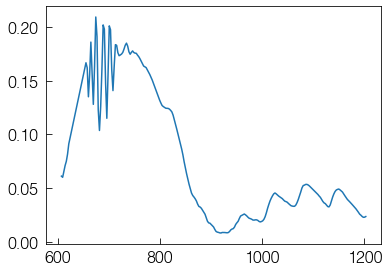

In [646]:
f0, s_norm_abs, s_norm_phase = sd.normalize_spectra(sample_spectra,sample_BB_spectra)
plt.plot(f0,s_norm_abs)

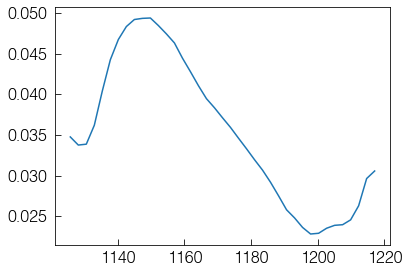

In [669]:
plt.plot(f0,snorm_abs)
#plt.xlim(600,1200)
#plt.ylim(0,.2)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


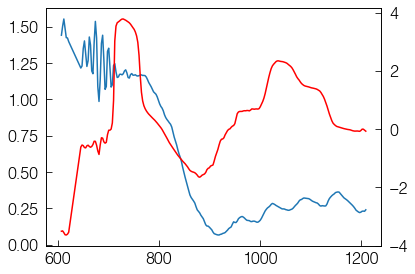

In [543]:
expand_envelope=2
f0, s_norm_abs, s_norm_phase, s_accumulated, _ = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=expand_envelope)
f0, s_norm_abs_ref, s_norm_phase_ref, s_accumulated_ref, _ = normalize_spectra2(ref_spectra,
                                                                      ref_BB_spectra,
                                                                      expand_envelope=expand_envelope,
                                                                               f0=f0)

plt.plot(f0,s_norm_abs/s_norm_abs_ref)
plt.twinx()
plt.plot(f0,np.unwrap(s_norm_phase-s_norm_phase_ref),color='r')

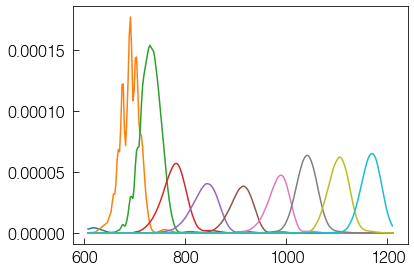

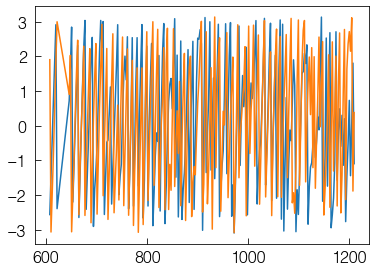

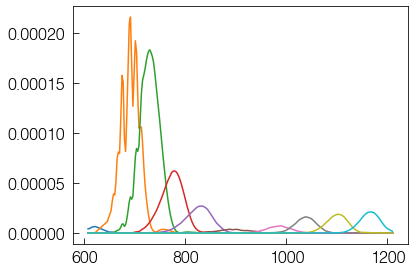

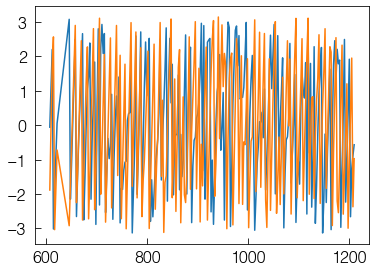

In [544]:
for s in s_accumulated_ref:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated_ref[:2]:
    plt.plot(f0,np.angle(s))

plt.figure()
for s in s_accumulated:
    plt.plot(f0,np.abs(s))


plt.figure()
for s in s_accumulated[:2]:
    plt.plot(f0,np.angle(s))

### Re-align phase

In [547]:
to_minimize1 = lambda ps,spectra: 1/np.real(summed_spectrum(ps,spectra))**2
to_minimize2 = lambda ps,spectra: 1/np.abs(summed_spectrum(ps,spectra))
to_minimize3 = lambda ps,spectra,spectrum0: np.abs((np.abs(summed_spectrum(ps,spectra))-spectrum0))**.5
def to_minimize4(ps,spectra,spectrum0,exp=1):
    
    spectrum = summed_spectrum(ps,spectra)
    delta = np.abs(np.abs(spectrum)-spectrum0)**exp
    pvariation = np.unwrap(np.angle(level_phase(spectrum,2)))
    penalty = np.sqrt(np.sum(np.diff(pvariation)**2))
    
    return delta#*penalty**1

#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1/2

spectra = s_accumulated_ref
stot_ref0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)

spectra = s_accumulated
stot0 = summed_spectrum0(spectra)
ps = [0]*len(spectra)
#ps = leastsq(to_minimize1,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize2,ps,args=(spectra,))[0]
#ps = leastsq(to_minimize4,ps,args=(spectra,stot0,2))[0]
ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

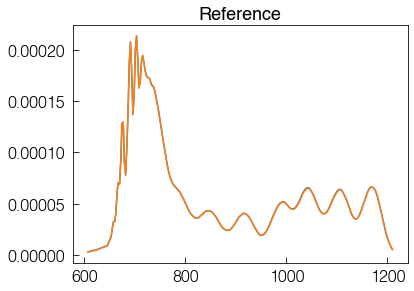

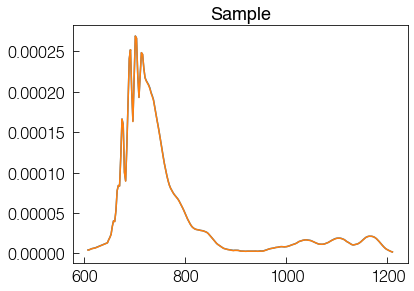

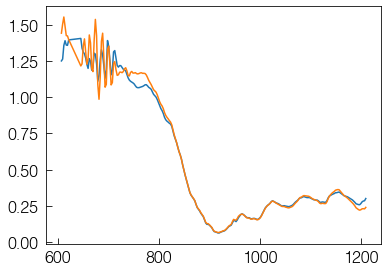

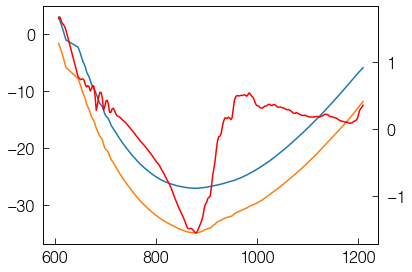

In [548]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.abs(snorm))
plt.plot(f0,s_norm_abs/s_norm_abs_ref)

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

# Iterative alignment (center-out)

In [566]:
def pair_difference(ps,spectrum,spectrum0,exp=1): #shift spectrum1 to match spectrum0
    p=ps[0]
    
    target = np.abs(spectrum0)+np.abs(spectrum)
    actual = np.abs(spectrum0+realigned(spectrum,p))
    delta = np.abs(target - actual)**exp
    #pvariation = np.unwrap(np.angle(level_phase(spectrum,2)))
    #pvariation=np.unwrap(np.angle(spectrum))
    #pvariation=np.diff(pvariation)
    #penalty = np.sqrt(np.sum(np.diff(pvariation)**2))
    
    return delta#*penalty**1

## BB 100% line spectrum

In [562]:
sample_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1.txt')
sample_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1_BB.txt')
ref_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2.txt')
ref_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2_BB.txt')

In [563]:
sample_spectra.shape

(180, 4095)

/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: overflow encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: invalid value encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:467: RuntimeWarning: invalid value encountered in true_divide
  s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref


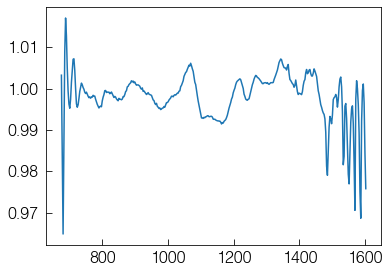

In [564]:
f0, s_norm_abs, s_norm_phase = sd.normalize_spectra(sample_spectra,sample_BB_spectra)
plt.plot(f0,s_norm_abs)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


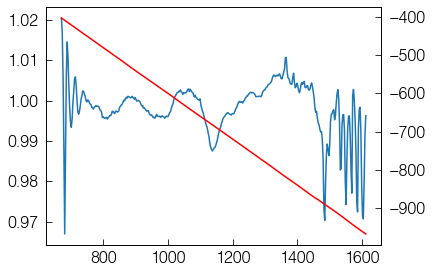

In [565]:
f0, s_norm_abs, s_norm_phase, s_accumulated, s_accumulated_ref = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=2)

plt.plot(f0,s_norm_abs)
plt.twinx()
plt.plot(f0,np.unwrap(-.6*f0+s_norm_phase),color='r')

### Re-align phase

In [610]:
#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1 #Somehow a medium exponent converges fastest

print('Reference spectra')
spectra = s_accumulated_ref
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
stot_ref = spectrum0
stot_ref0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)


    
print('Sample spectra')
incremental_spectra=[]

spectra = s_accumulated
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
stot = spectrum0
stot0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

Reference spectra
[-0.0008958118649234329, -0.0011195406949046631, -0.0013590927793448956, -0.000957211938153367, -0.0002986377094398062, -0.0022980230937164783, -0.00037778162760968037, -0.0006108858912587874, -0.0011714091619452905, -0.0010923425165310847, -0.0004942819557543167, 0.0001402463615774525, -0.00042548662128759725, 0.0005769682002542968, -0.0005363670197810976, -0.0007698984185138594, -0.0005149594269811672, -0.00019100712785110577, 0.0006337412720241983, 9.659233402845203e-05, 0.00017729380322175603, 0.0005601316247150532, 5.7159422297147744e-05, 0.0009964171083484117, 0.0007076733372683763, 0.00047836329703475236, 0.00017953544051505917, 0.0005331159819294219, 0.0008482693008202586, 0.00029361763236850666, 0, -0.0012624384344214732, -0.0018511883098150633, -0.0012366395038368556, -0.0015704766624625112, -0.0018815604279759034]
Sample spectra
[-0.0020529040641544035, -0.00137552520454089, -0.0013484412487628642, -0.0021594959948947993, -0.0014883765913512328, -0.00202936

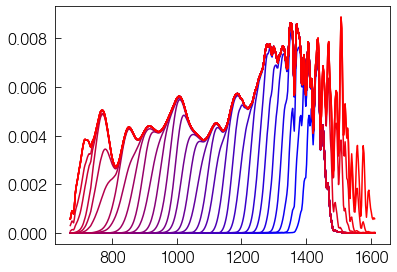

In [603]:
N=len(incremental_spectra)
cs=plotting.bluered_colors(N)
for i in range(N):
    plt.plot(f0,np.abs(incremental_spectra[i]),color=next(cs))

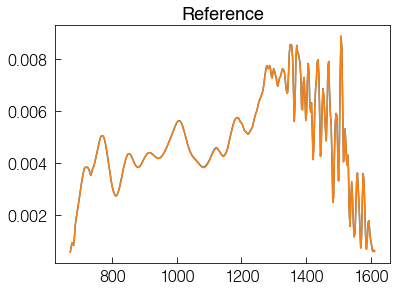

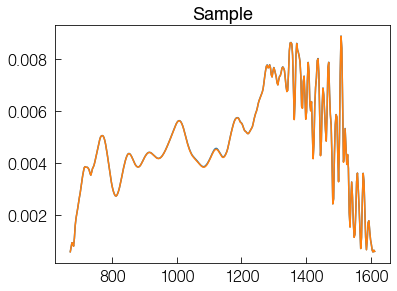

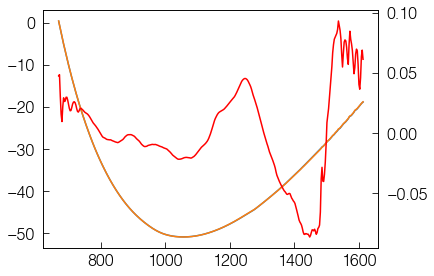

In [611]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

## TiO2 spectrum

In [624]:
# Reference was some crummy piece of metal contact on the surface
sample_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra.txt')
sample_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra_BB.txt')
ref_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra.txt')
ref_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra_BB.txt')

In [625]:
sample_spectra.shape

(50, 4095)

/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: overflow encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:466: RuntimeWarning: invalid value encountered in true_divide
  else: s_norm = s_accumulated / s_accumulated_abs_ref
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay.py:467: RuntimeWarning: invalid value encountered in true_divide
  s_norm_abs = s_accumulated_abs / s_accumulated_abs_ref


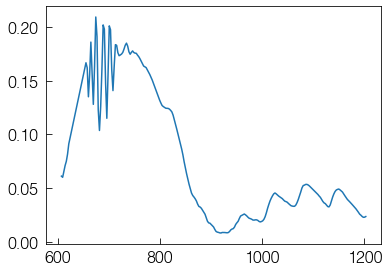

In [626]:
f0, s_norm_abs, s_norm_phase = sd.normalize_spectra(sample_spectra,sample_BB_spectra)
plt.plot(f0,s_norm_abs)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


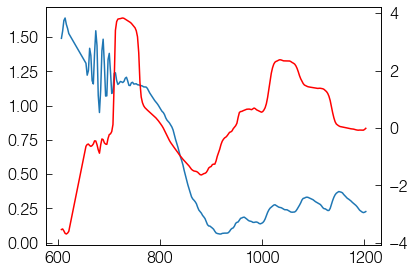

In [635]:
expand_envelope=1
f0, s_norm_abs, s_norm_phase, s_accumulated, _ = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=expand_envelope)
f0, s_norm_abs_ref, s_norm_phase_ref, s_accumulated_ref, _ = normalize_spectra2(ref_spectra,
                                                                      ref_BB_spectra,
                                                                      expand_envelope=expand_envelope,
                                                                               f0=f0)

plt.plot(f0,s_norm_abs/s_norm_abs_ref)
plt.twinx()
plt.plot(f0,np.unwrap(s_norm_phase-s_norm_phase_ref),color='r')

### Re-align phase

In [636]:
#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1/2 #Somehow a medium exponent converges fastest

print('Reference spectra')
spectra = s_accumulated_ref
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
stot_ref = spectrum0
stot_ref0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)


    
print('Sample spectra')
incremental_spectra=[]

spectra = s_accumulated
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
stot = spectrum0
stot0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

Reference spectra
[-0.0010531013859388892, 0, -0.00012900305671453765, -0.0002108168110573952, -0.0004389275811893897, -0.0009549264171703547, -0.0006103112533125166, -0.0008195965616757964, -0.0015489182810840957, -0.0015238627527884286]
Sample spectra
[0.0002776841094007608, 0, 0.0003396314248863784, 0.0005961766310960573, 0.00038521113570658377, -0.00032702105543015665, -0.0006238522006541972, -0.001113986111853092, -0.001237823831280665, -0.0007689715407750886]


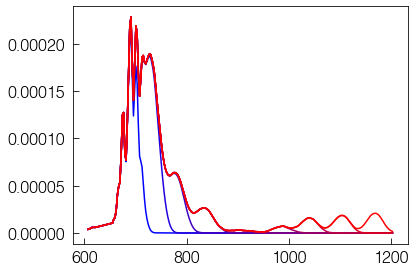

In [637]:
N=len(incremental_spectra)
cs=plotting.bluered_colors(N)
for i in range(N):
    plt.plot(f0,np.abs(incremental_spectra[i]),color=next(cs))

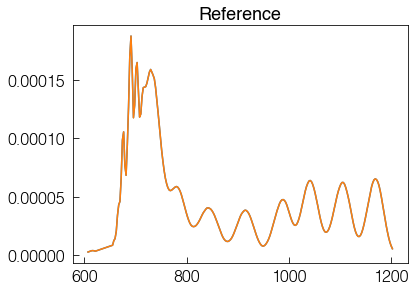

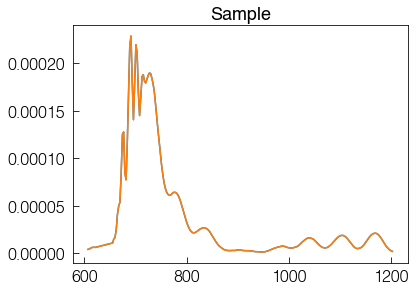

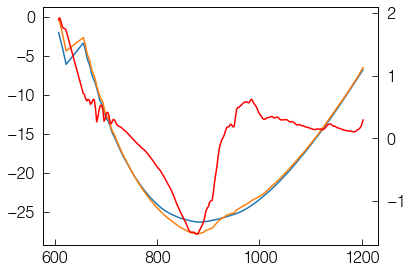

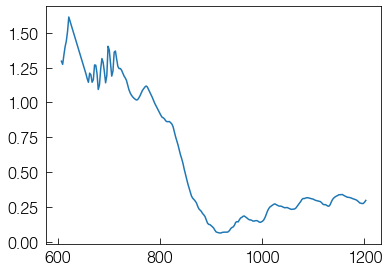

In [639]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

plt.figure()
plt.plot(f0,np.abs(stot/stot_ref))

## SiO2 spectrum

In [615]:
sample_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm.txt')
sample_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm_BB.txt')
ref_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1.txt')
ref_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1_BB.txt')

In [616]:
sample_spectra.shape

(50, 4095)

### Inspect un-corrected phase contrast

/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in true_divide
/Users/alexandersmcleod/opt/anaconda3/envs/SciComp/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


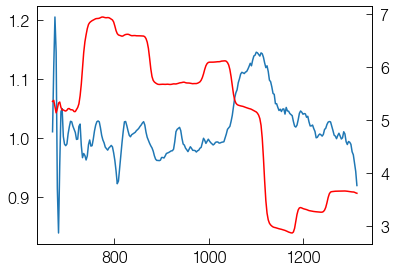

In [617]:
expand_envelope=1
f0, s_norm_abs, s_norm_phase, s_accumulated, _ = normalize_spectra2(sample_spectra,
                                                                      sample_BB_spectra,
                                                                      expand_envelope=expand_envelope)
f0, s_norm_abs_ref, s_norm_phase_ref, s_accumulated_ref, _ = normalize_spectra2(ref_spectra,
                                                                      ref_BB_spectra,
                                                                      expand_envelope=expand_envelope,
                                                                               f0=f0)

plt.plot(f0,s_norm_abs/s_norm_abs_ref)
plt.twinx()
plt.plot(f0,np.unwrap(s_norm_phase-s_norm_phase_ref),color='r')

### Re-align phase

In [621]:
#The result seems robust but potentially A LOT of evaluations are needed
lskwargs=dict(factor=.1,maxfev=int(1e5))
error_exp=1/2 #Somehow a medium exponent converges fastest

print('Reference spectra')
spectra = s_accumulated_ref
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
stot_ref = spectrum0
stot_ref0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot_ref0,error_exp),**lskwargs)[0]
stot_ref = summed_spectrum(ps,spectra)
stot_ref = level_phase(stot_ref)


    
print('Sample spectra')
incremental_spectra=[]

spectra = s_accumulated
Nspectra=len(spectra)
ps = [0]*Nspectra
center_ind = np.argmax([np.abs(s).max() for s in spectra])
spectrum0 = spectra[center_ind]
spectra_new = [0]*Nspectra
spectra_new[center_ind] = spectrum0
for i in range(center_ind):
    workind=center_ind-(i+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
for j in range(Nspectra-(center_ind+1)):
    workind=center_ind+(j+1)
    #print('working on index %i'%workind)
    spectrum=spectra[workind]
    p = leastsq(pair_difference,[0],
                args=(spectrum,spectrum0,error_exp),
                **lskwargs)[0][0]
    ps[workind]=p
    spectra_new[workind] = realigned(spectrum,p)
    spectrum0 = np.sum(spectra_new,axis=0)
    incremental_spectra.append(spectrum0)
stot = spectrum0
stot0 = summed_spectrum0(spectra)
print(ps)

ps = leastsq(to_minimize4,ps,args=(spectra,stot0,error_exp),**lskwargs)[0]
stot = summed_spectrum(ps,spectra)
stot = level_phase(stot)

snorm = level_phase(stot/stot_ref,order=1)

Reference spectra
[0.00020769460475800365, 0.0008495691833042912, 0.000698050860379615, -0.00014659147509607428, 0.00015648390560811802, 0.0004479564637287353, 8.897979238845691e-05, -0.0005018349713369158, -0.00024465199197580903, 0]
Sample spectra
[0.0009910729148445156, 0.00043740086734521925, 0.0005326707145767361, -0.0003046915598617891, -0.0004293743768267588, 0.0005994966681959065, -9.458718099396293e-05, 0.0005552030534730016, -3.072010469331734e-05, 0]


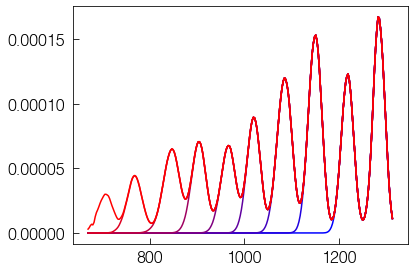

In [622]:
N=len(incremental_spectra)
cs=plotting.bluered_colors(N)
for i in range(N):
    plt.plot(f0,np.abs(incremental_spectra[i]),color=next(cs))

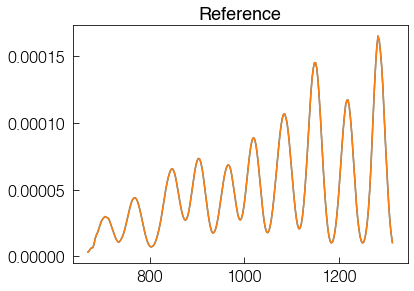

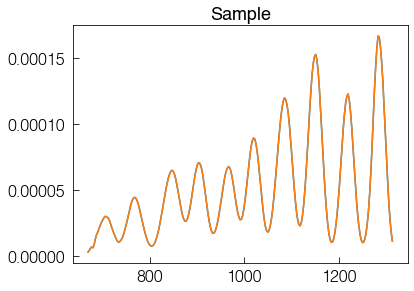

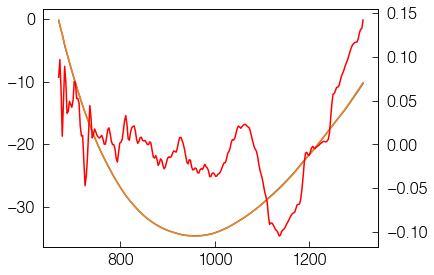

In [623]:
plt.plot(f0,stot_ref0,f0,np.abs(stot_ref))
plt.title('Reference')

plt.figure()
plt.plot(f0,stot0,f0,np.abs(stot))
plt.title('Sample')

plt.figure()
plt.plot(f0,np.unwrap(np.angle(level_phase(stot_ref))))
plt.plot(f0,np.unwrap(np.angle(level_phase(stot))))
plt.twinx()
plt.plot(f0,np.unwrap(np.angle(level_phase(snorm))),color='r')

# Try optimization of BB calibration factor

## General tools

In [981]:
def summed_spectrum(spectra,abs=False):
    
    if abs: spectrum = np.sum([np.abs(s) for s in spectra],axis=0)
    else: spectrum = np.sum([s for s in spectra],axis=0)
    
    spectrum[~np.isfinite(spectrum)]=0
    
    return spectrum

def norm_spectrum(f,spectra,
                  f_ref,spectra_ref,
                  abs=False,valid_thresh=.01):
    
    spectrum = summed_spectrum(spectra,abs=abs)
    spectrum_ref = summed_spectrum(spectra_ref,abs=abs)
    spectrum_ref = interp1d(x=f_ref,y=spectrum_ref,
                           **interp_kwargs)(f)
        
    thresh = valid_thresh*np.abs(spectrum_ref).max()
    where_valid = np.abs(spectrum_ref)>thresh
    snorm = (spectrum/spectrum_ref)[where_valid]
    f = f[where_valid]
        
    return f,snorm

## Calibration optimization tools

In [999]:


def BB_envelope_and_align(spectra,spectra_ref,expand_envelope=1,\
                         BB_phase=False,valid_thresh=.01,
                         factor=1,optimize_calibration=True):
    
    global ss, ss_interp_ref, env_params, f0
    
    spectra = np.array(spectra)
    spectra_ref = np.array(spectra_ref)

    Nrows = 5
    assert len(spectra)==len(spectra_ref),\
            "Applying envelope requires same number of accumulations for both analyte and reference"

    assert len(spectra) % Nrows == 0, 'Input spectra must come as stacked groups of %i row vectors'%Nrows
    assert len(spectra_ref) % Nrows == 0, 'Input spectra must come as stacked groups of %i row vectors'%Nrows
    Nspectra = np.max( (len(spectra) // Nrows, 1) )
    
    # Establish some mutual frequency axis

    f0_given=False
    all_fs = np.append([], [spectra[Nrows * i] for i in range(Nspectra)] \
                           + [spectra_ref[Nrows * i] for i in range(Nspectra)] )
    Nf = len(all_fs)//(2*Nspectra)
    f0 = np.linspace(np.min(all_fs),
                     np.max(all_fs),
                     Nf)
        
    # Collect all the spectra and the envelopes
    ss=[]
    ss_interp_ref=[]
    env_params=[]
    for i in range(Nspectra):

        ## Analyte spectrum components
        f = spectra[Nrows * i]
        sabs = spectra[Nrows * i + 1]
        sphase = spectra[Nrows * i + 2]
        s = sabs * np.exp(1j * sphase)

        # In case we have invalid entries (zeros), remove them
        where_valid = np.isfinite(f) * (f > 0)
        f = f[where_valid]
        s = s[where_valid]
        ss.append( interp1d(f, s, **sd.interp_kwargs)(f0) )

        ## Reference spectrum components
        f_ref = spectra_ref[Nrows * i]
        sabs_ref = spectra_ref[Nrows * i + 1]
        sphase_ref = spectra_ref[Nrows * i + 2]
        # Discard the BB phase if we don't want it
        if BB_phase: s_ref = sabs_ref * np.exp(1j * sphase_ref)
        else: s_ref = sabs_ref

        # In case we have invalid entries (zeros), remove them
        where_valid = np.isfinite(f_ref) * (f_ref > 0)
        f_ref = f_ref[where_valid]
        s_ref = s_ref[where_valid]
        ss_interp_ref.append( interp1d(f_ref, s_ref,  **sd.interp_kwargs) )
        
        env_params.append( spectra_ref[Nrows * i + 4][:3] )
    
    # Find calibration factor     
    def calibrate_spectra(factor,
                          ss,ss_interp_ref,env_params):
        
        spectra_cal=[]
        spectra_BB_cal=[]
        for i in range(Nspectra):
            spectrum=ss[i]
            env = sd.spectral_envelope(f0*factor, *env_params[i],
                                        expand_envelope=expand_envelope)
            env /= env.max()
            spectrum_ref = ss_interp_ref[i](f0*factor)
            spectra_cal.append( env*spectrum)
            spectra_BB_cal.append( env*spectrum_ref )
        
        return spectra_cal,spectra_BB_cal
    
    def to_minimize(params,
                   ss,ss_interp_ref,env_params):
        factor, = params

        spectra_cal,spectra_BB_cal=calibrate_spectra(factor,
                                                    ss,ss_interp_ref,env_params)
        f,s_abs_norm = norm_spectrum(f0,spectra_cal,
                                     f0,spectra_BB_cal,
                                     valid_thresh=valid_thresh,abs=True)
        d1 = np.gradient(s_abs_norm)/s_abs_norm

        return np.mean(np.abs(d1)**(1/2)) #minimize first derivative
    
    # Optimize calibration between BB and sample, if called for
    args=(ss,ss_interp_ref,env_params)
    if optimize_calibration:
        result = minimize(to_minimize,(factor,),method='Nelder-Mead',args=args)
        factor=result.x[0]
        print(factor)
    
    spectra_cal,spectra_BB_cal=calibrate_spectra(factor,*args)
    
    return f0,spectra_cal,spectra_BB_cal

1.00185546875
1.0060546875


Text(0.5, 1.0, 'Normalized to reference')

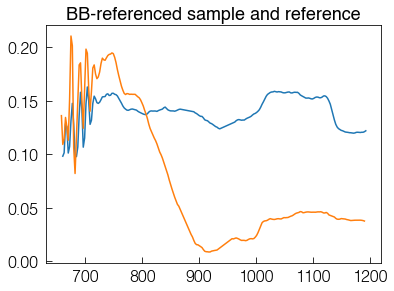

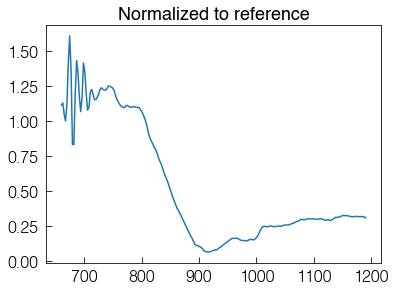

In [1051]:
# Reference was some crummy piece of metal contact on the surface
sample_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra.txt')
sample_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra_BB.txt')
ref_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra.txt')
ref_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra_BB.txt')

envelope_width=1
f_cal_ref,spectra_cal_ref,spectra_BB_cal_ref = BB_envelope_and_align(ref_spectra,ref_BB_spectra,expand_envelope=envelope_width,
                                                      factor=1,optimize_calibration=True)
f_ref,snorm_abs_ref = norm_spectrum(f_cal_ref,spectra_cal_ref,
                                    f_cal,spectra_BB_cal_ref,
                                          abs=True,valid_thresh=.1)
plt.plot(f_ref,snorm_abs_ref)

f_cal,spectra_cal,spectra_BB_cal = BB_envelope_and_align(sample_spectra,sample_BB_spectra,expand_envelope=envelope_width,
                                                      factor=1,optimize_calibration=True)
f,snorm_abs = norm_spectrum(f_cal,spectra_cal,
                            f_cal,spectra_BB_cal,
                                      abs=True,valid_thresh=.1)
plt.plot(f,snorm_abs)
plt.title('BB-referenced sample and reference')

interp_ref=interp1d(x=f_ref,y=snorm_abs_ref,**interp_kwargs)
plt.figure()
plt.plot(f,snorm_abs/interp_ref(f))
plt.title('Normalized to reference')

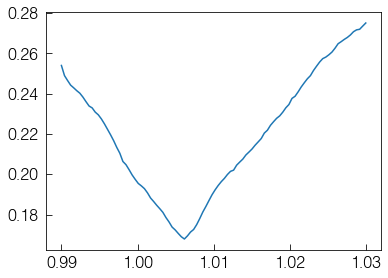

In [865]:
factors=np.linspace(.99,1.03,100)
plt.plot(factors,[to_minimize([f]) for f in factors])

(0.0, 0.3)

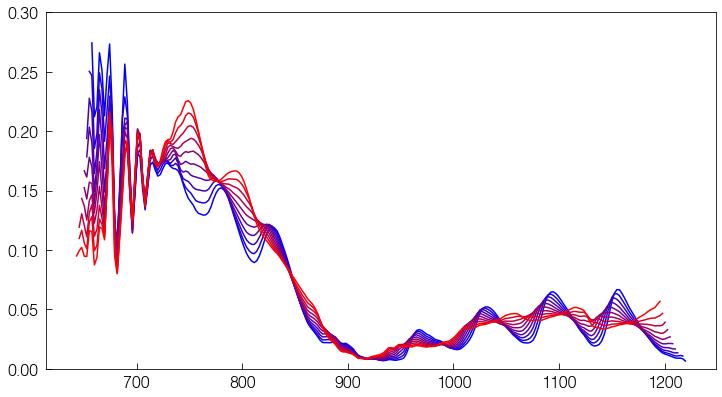

In [867]:
f=plt.figure(figsize=(12,6))
factors = np.linspace(.99,1.01,10)
N=len(factors)
cs=plotting.bluered_colors(N)
ss_shifted=[]
for f in factors:
    s,where_valid = spectrum_norm(f,abs=True)
    plt.plot(f0[where_valid],s[where_valid],color=next(cs))
    ss_shifted.append(s[where_valid])

plt.ylim(0,.3)

## Phase alignment tools

In [1127]:
def phase_displace(f,s,p):
    
    return np.exp(1j*f*p)*s

def level_phase(f,s,order=1):
    
    p=np.unwrap(np.angle(s))
    m = np.polyfit(x=f,y=p,deg=order)
    #m[-1]=0 #no overall phase offsets
    p -= np.polyval(m,f)
    
    return np.abs(s)*np.exp(1j*p)

def pair_difference(ps,f,spectrum,spectrum0,exp=1): #shift spectrum1 to match spectrum0
    p=ps[0]
    
    target = np.abs(spectrum0)+np.abs(spectrum)
    actual = np.abs(spectrum0+phase_displace(f,spectrum,p))
    delta = np.abs(target - actual)**exp
    
    """pvariation = np.unwrap(np.angle(level_phase(spectrum,2)))
    pvariation=np.unwrap(np.angle(spectrum))
    pvariation=np.diff(pvariation)
    penalty = np.sqrt(np.sum(np.diff(pvariation)**2))"""
    
    return delta#*penalty**1

def overall_difference(ps,f,spectra,spectrum0,exp=1):
    
    spectra = [phase_displace(f,s,p) for s,p in zip(spectra,ps)]
    spectrum = summed_spectrum(spectra,abs=False)
    delta = np.abs(np.abs(spectrum)-np.abs(spectrum0))**exp
    pvariation = np.unwrap(np.angle(level_phase(f,spectrum,1)))
    #pvariation=np.unwrap(np.angle(spectrum))
    #pvariation=np.diff(pvariation)
    penalty = np.sqrt(np.sum(np.diff(pvariation)**2))
    
    return delta*penalty**(1/2)

def phase_aligned_spectrum(f,spectra,verbose=False):

    #The result seems robust but potentially A LOT of evaluations are needed
    lskwargs=dict(factor=.01,maxfev=int(1e5))
    error_exp=1 #Somehow a medium exponent converges fastest

    Nspectra=len(spectra)
    ps = [0]*Nspectra
    center_ind = np.argmax([np.abs(s).max() for s in spectra])
    spectrum0 = spectra[center_ind]
    spectra_new = [0]*Nspectra
    spectra_new[center_ind] = spectrum0
    for i in range(center_ind):
        workind=center_ind-(i+1)
        if verbose: print('working on index %i'%workind)
        spectrum=spectra[workind]
        p = leastsq(pair_difference,[0],
                    args=(f,spectrum,spectrum0,error_exp),
                    **lskwargs)[0][0]
        ps[workind]=p
        spectra_new[workind] = phase_displace(f,spectrum,p)
        spectrum0 = np.sum(spectra_new,axis=0)
    for j in range(Nspectra-(center_ind+1)):
        workind=center_ind+(j+1)
        if verbose: print('working on index %i'%workind)
        spectrum=spectra[workind]
        p = leastsq(pair_difference,[0],
                    args=(f,spectrum,spectrum0,error_exp),
                    **lskwargs)[0][0]
        ps[workind]=p
        spectra_new[workind] = phase_displace(f,spectrum,p)
        spectrum0 = np.sum(spectra_new,axis=0)
    print('Phase compensations (2pi*cm):\n\t',
          '\n\t'.join((str(p) for p in ps)))

    stot = spectrum0
    """stot0 = summed_spectrum(spectra,abs=False)
    ps = leastsq(overall_difference,ps,
                 args=(f,spectra,stot0,2),
                 **lskwargs)[0]
    stot = summed_spectrum([phase_displace(f,s,p) for s,p 
                                in zip(spectra,ps)],
                               abs = False)"""
    #stot = level_phase(f,stot)
    
    return stot

[0.00018298497963200133, 0, 0.0003695464417870891, 0.0006297397566289161, 0.0004127267718857674, -0.00025247063539301384, -0.0005279499516657688, -0.001026084770532951, -0.0011515182706279018, -0.0007102329944571578]
[-3.393457934947049e-05, 0, -0.00012983860729076549, -0.00021120794912913728, -0.0004392400117285528, -0.0009652128995945814, -0.0005975698011775895, -0.0008258639650007139, -0.0015690725953593709, -0.0015143059355122628]


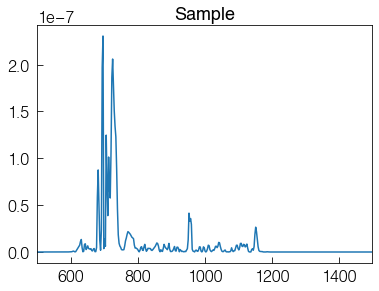

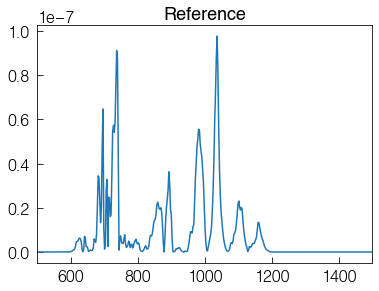

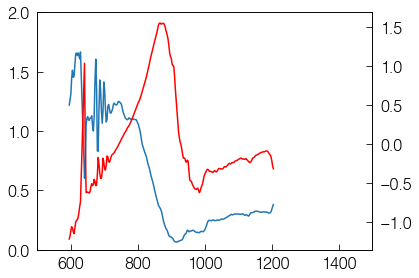

In [1096]:
spectrum1 = phase_aligned_spectrum(f_cal,spectra_cal,verbose=False)
plt.plot(f_cal,summed_spectrum(spectra_cal,abs=True)-np.abs(spectrum1))
plt.xlim(500,1500); plt.title('Sample')
f1,spectrum1 = norm_spectrum(f_cal,[spectrum1],
                             f_cal,spectra_BB_cal)

spectrum2 = phase_aligned_spectrum(f_cal_ref,spectra_cal_ref,verbose=False)
plt.figure()
plt.plot(f_cal_ref,summed_spectrum(spectra_cal_ref,abs=True)-np.abs(spectrum2))
plt.xlim(500,1500); plt.title('Reference')
f2,spectrum2 = norm_spectrum(f_cal_ref,[spectrum2],
                             f_cal_ref,spectra_BB_cal_ref)

plt.figure()
f,snorm = norm_spectrum(f1,[spectrum1],
                  f2,[spectrum2],
                  abs=False,valid_thresh=.1)

plt.plot(f,np.abs(snorm))
plt.ylim(0,2)
plt.xlim(500,1500)
plt.twinx()
plt.plot(f,-np.unwrap(np.angle(level_phase(f,snorm,order=1))),color='r')

## The outcome

* Calibration optimization is stable w.r.t. starting point of optimization, if we minimize 1st derivatives
* Reference and sample somehow have differential BB calibration factors?  What is drifting, BB mirror pointing?
* Everything can be put together with the functions under General tools, calibration tools, phase tools...

# Put it all together!!

In [1116]:
def all_together(sample_spectra,sample_BB_spectra,
                 ref_spectra,ref_BB_spectra,
                envelope_width=1,valid_thresh=.1,
                 optimize_calibration=True,
                 optimize_phase=True,
                check_phase_alignment=True):
    
    print('Optimizing BB calibration for sample...')
    f_cal_ref,spectra_cal_ref,spectra_BB_cal_ref = BB_envelope_and_align(ref_spectra,ref_BB_spectra,
                                                                         expand_envelope=envelope_width,
                                                          factor=1,optimize_calibration=optimize_calibration,
                                                                        valid_thresh=valid_thresh)

    print('Optimizing BB calibration for reference...')
    f_cal,spectra_cal,spectra_BB_cal = BB_envelope_and_align(sample_spectra,sample_BB_spectra,
                                                             expand_envelope=envelope_width,
                                                          factor=1,optimize_calibration=optimize_calibration,
                                                            valid_thresh=valid_thresh)
    
    if optimize_phase:
        print('Aligning phase for sample...')
        spectrum1 = phase_aligned_spectrum(f_cal,spectra_cal,verbose=False)
        print('Aligning phase for reference...')
        spectrum2 = phase_aligned_spectrum(f_cal_ref,spectra_cal_ref,verbose=False)
        
        if check_phase_alignment:
            plt.figure()
            a=summed_spectrum(spectra_cal,abs=True)
            b=np.abs(spectrum1)
            plt.plot(f_cal,a,f_cal,b)
            plt.twinx()
            plt.plot(f_cal,a-b,color='r')
            plt.xlim(500,2000); plt.title('Sample')


            plt.figure()
            a=summed_spectrum(spectra_cal_ref,abs=True)
            b=np.abs(spectrum2)
            plt.plot(f_cal,a,f_cal,b)
            plt.twinx()
            plt.plot(f_cal,a-b,color='r')
            plt.xlim(500,2000); plt.title('Reference')
            
        spectra_cal=[spectrum1]
        spectra_cal_ref=[spectrum2]
        
    f1,spectrum1 = norm_spectrum(f_cal,spectra_cal,
                                 f_cal,spectra_BB_cal,
                                valid_thresh=valid_thresh)
    f2,spectrum2 = norm_spectrum(f_cal_ref,spectra_cal_ref,
                                 f_cal_ref,spectra_BB_cal_ref,
                                valid_thresh=valid_thresh)

    f,snorm = norm_spectrum(f1,[spectrum1],
                      f2,[spectrum2],
                      abs=False,valid_thresh=valid_thresh)
    
    return f,snorm

## TiO2

Optimizing BB calibration for sample...
1.00185546875
Optimizing BB calibration for reference...
1.0060546875
Aligning phase for sample...
[0.00018298497963200133, 0, 0.0003695464417870891, 0.0006297397566289161, 0.0004127267718857674, -0.00025247063539301384, -0.0005279499516657688, -0.001026084770532951, -0.0011515182706279018, -0.0007102329944571578]
Aligning phase for reference...
[-3.393457934947049e-05, 0, -0.00012983860729076549, -0.00021120794912913728, -0.0004392400117285528, -0.0009652128995945814, -0.0005975698011775895, -0.0008258639650007139, -0.0015690725953593709, -0.0015143059355122628]


Text(0, 0.5, 'Phase (rad)')

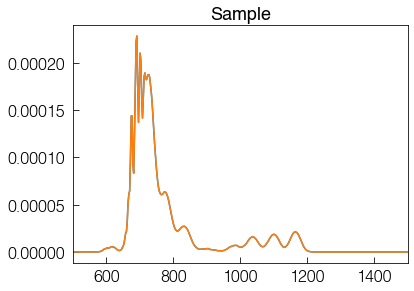

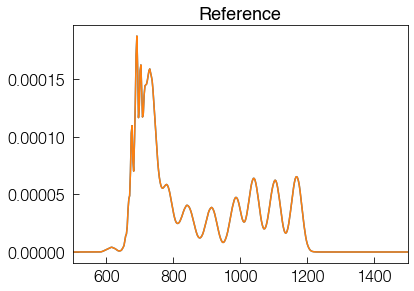

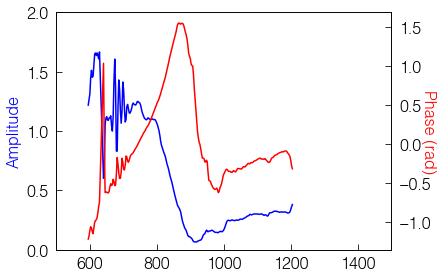

In [1045]:
sample_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra.txt')
sample_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Sample spectra_BB.txt')
ref_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra.txt')
ref_BB_spectra=np.loadtxt('Test Data/TiO2 spectra/Reference spectra_BB.txt')

f,snorm = all_together(sample_spectra,sample_BB_spectra,
                         ref_spectra,ref_BB_spectra,
                        envelope_width=1,valid_thresh=.01,
                         optimize_calibration=True,
                        check_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,2)
plt.ylabel('Amplitude',color='b')
plt.xlim(500,1500)
plt.twinx()
plt.plot(f,-np.unwrap(np.angle(level_phase(f,snorm,order=1))),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r')

## SiO2

Optimizing BB calibration for sample...
0.99990234375
Optimizing BB calibration for reference...
0.9995361328125
Aligning phase for sample...
[0.0009930352472495476, 0.00045073564924248086, 0.0005475082129024917, -0.00029725814418962883, -0.00044438303230550264, 0.000568192781816037, -0.00012058835598602777, 0.0005396547368155051, -3.4875190108908434e-05, 0]
Aligning phase for reference...
[0.00029249546566695415, 0.0009251757308906936, 0.0007362166706909014, -0.00011590004240285374, 0.00017657548369130906, 0.00046568745617687286, 0.00011193119849535353, -0.0004908721298947569, -0.00023860413795407604, 0]


Text(0, 0.5, 'Phase (rad)')

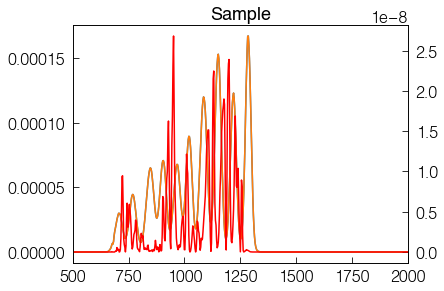

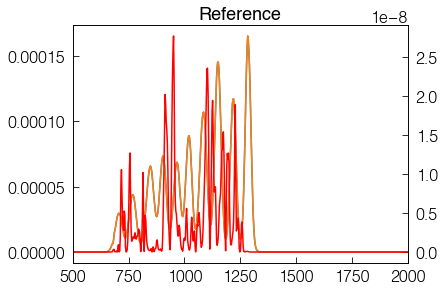

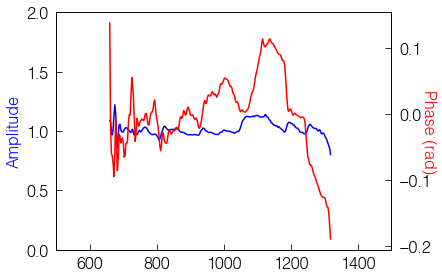

In [1114]:
sample_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm.txt')
sample_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Sample spectra - sio2 100 nm_BB.txt')
ref_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1.txt')
ref_BB_spectra=np.loadtxt('Test Data/SiO2 spectra/Ref spectra - silicon 1_BB.txt')

f,snorm = all_together(sample_spectra,sample_BB_spectra,
                         ref_spectra,ref_BB_spectra,
                        envelope_width=1,valid_thresh=.01,
                         optimize_calibration=True,
                        check_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,2)
plt.ylabel('Amplitude',color='b')
plt.xlim(500,1500)
plt.twinx()
plt.plot(f,-np.unwrap(np.angle(level_phase(f,snorm,order=1))),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r')

## Gold

Optimizing BB calibration for sample...
1.0
Optimizing BB calibration for reference...
1.000006103515625
Aligning phase for sample...
Phase compensations (2pi*cm):
	 -0.0020809996469902696
	-0.001400078422369995
	-0.0013719044815737394
	-0.0021729679839461416
	-0.0015073993806991493
	-0.002049217098169535
	-0.001636209945479278
	-0.001557647409662601
	-0.0005996999223036981
	-0.0005739804146020366
	-0.0014455610499893832
	-0.0007647945783998772
	-0.0013510857020281597
	-0.00040938741326200035
	-0.0015053429330762404
	-0.0005222337682808562
	-0.0011218927395097006
	-0.000799319771323886
	-0.0001640457769766894
	-0.00037604619210603735
	-0.0006108639254858442
	-0.0002911157121496664
	-0.0008425643360808709
	-0.00019312339630016468
	-0.00018075242373523728
	-0.00045877268431063846
	0.000501726598612527
	0.00019411876210637577
	0.00023806045778955822
	-1.6605327208848135e-05
	0
	-0.0018441261153649673
	0.002020474134141193
	0.0014665032321503808
	0.0020447354998729505
	-0.00140177602755511

(-1.0, 1.5)

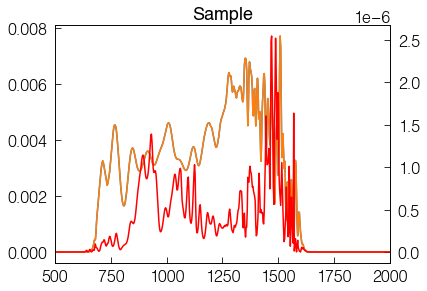

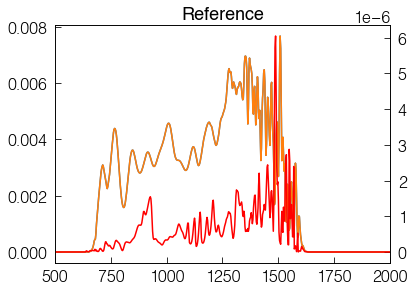

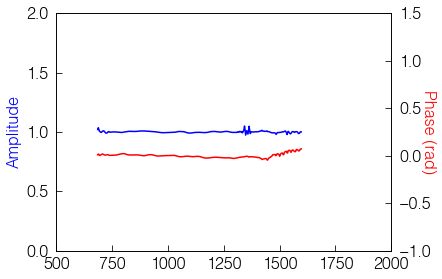

In [1128]:
sample_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1.txt')
sample_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1_BB.txt')
ref_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2.txt')
ref_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2_BB.txt')

f,snorm = all_together(sample_spectra,sample_BB_spectra,
                         ref_spectra,ref_BB_spectra,
                        envelope_width=1,valid_thresh=.1,
                         optimize_calibration=True,
                       optimize_phase=True,
                        check_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,2)
plt.ylabel('Amplitude',color='b')
plt.xlim(500,2000)
plt.twinx()
plt.plot(f,-np.unwrap(np.angle(level_phase(f,snorm,order=1))),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r')
plt.ylim(-1,1.5)

## Object-oriented pipeline

### TiO2

Processing sample spectra...
Aligning and enveloping spectra...
Identified calibration factor: 1.0060546875
Aligning phase...


C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\

Processing reference spectra...
Aligning and enveloping spectra...
Identified calibration factor: 1.00185546875
Aligning phase...


C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: overflow encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python

Processing sample spectra...
Aligning and enveloping spectra...
Aligning phase...
Processing reference spectra...
Aligning and enveloping spectra...
Aligning phase...


C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: overflow encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python

Text(0, 0.5, 'Phase (rad)')

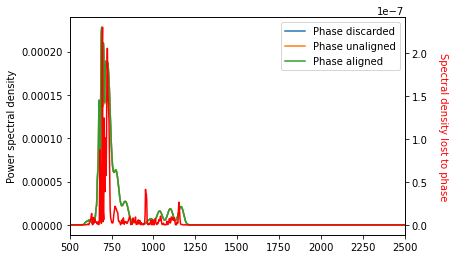

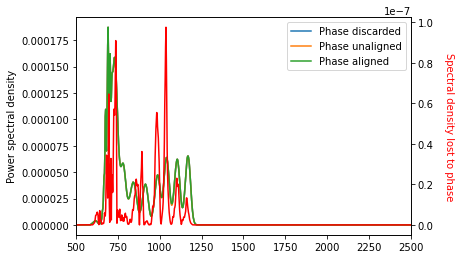

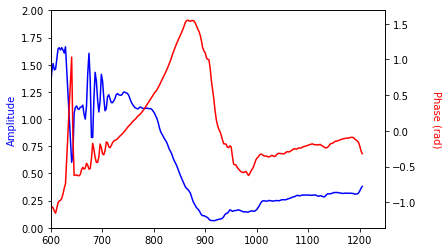

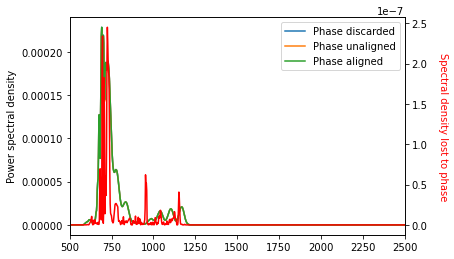

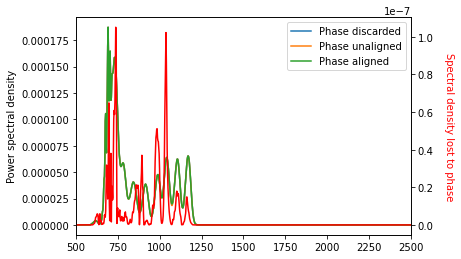

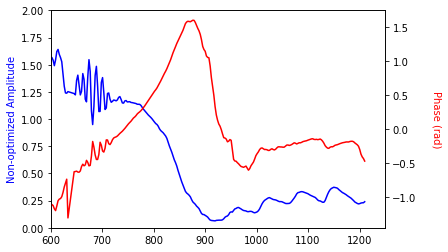

In [18]:
sample_spectra=np.loadtxt('Test Data\TiO2 spectra\Sample spectra.txt')
sample_BB_spectra=np.loadtxt('Test Data\TiO2 spectra\Sample BB spectra.txt')
ref_spectra=np.loadtxt('Test Data\TiO2 spectra\Reference spectra.txt')
ref_BB_spectra=np.loadtxt('Test Data\TiO2 spectra\Reference BB spectra.txt')

reload(sd)
SP = sd.SpectralProcessor(sample_spectra,sample_BB_spectra,
                         ref_spectra,ref_BB_spectra)

f,snorm = SP(envelope_width=1,valid_thresh=.01,
                         optimize_BB=True,
                       optimize_phase=True,
                        view_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,2)
plt.ylabel('Amplitude',color='b')
plt.xlim(600,1250)
plt.twinx()
plt.plot(f,-SP.get_phase(f,snorm),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r',labelpad=25)
#plt.ylim(-1,1.5)

f,snorm = SP(envelope_width=1,valid_thresh=.01,
                         optimize_BB=False,
                       optimize_phase=True,
                        view_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,2)
plt.ylabel('Non-optimized Amplitude',color='b')
plt.xlim(600,1250)
plt.twinx()
plt.plot(f,-SP.get_phase(f,snorm),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r',labelpad=25)
#plt.ylim(-1,1.5)

In [13]:
pdb on

Automatic pdb calling has been turned ON


Aligning and enveloping spectra...
Identified calibration factor: 1.0060546875
Processing sample spectra...
Aligning and enveloping spectra...


C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: overflow encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]


Identified calibration factor: 1.0060546875
Aligning phase...
Processing reference spectra...
Aligning and enveloping spectra...


C:\Users\mnopl\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\mnopl\Desktop\Software\mnOPSuite\PRISM\python\scandelay_FTIR.py:355: RuntimeWarning: overflow encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]


Identified calibration factor: 1.00185546875
Aligning phase...


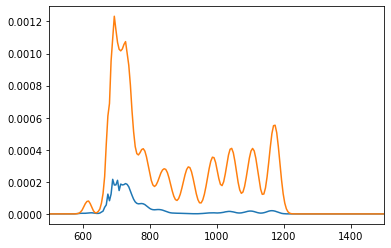

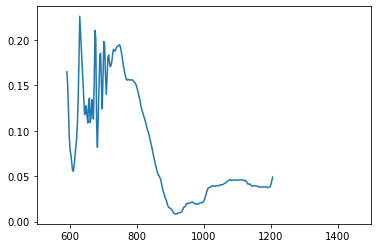

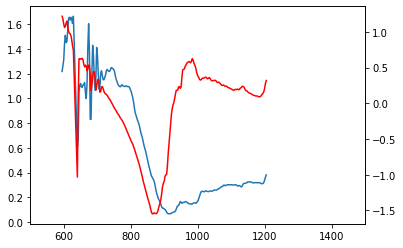

In [21]:
reload(sd)

f,s,sp = sd.accumulate_spectra(sample_spectra, apply_envelope=True, expand_envelope=1)
plt.plot(f,s)
f,s,sp = sd.accumulate_spectra(sample_BB_spectra, apply_envelope=True, expand_envelope=1)
plt.plot(f,s)
plt.xlim(500,1500)

plt.figure()
f,sabs,sphase = sd.BB_referenced_spectrum(sample_spectra,sample_BB_spectra,
                          apply_envelope=True, envelope_width=1,
                           optimize_BB=True,
                          optimize_phase=False,abs_only=True,
                           valid_thresh=.01)
plt.plot(f,sabs)
plt.xlim(500,1500)

plt.figure()
f,sabs,sphase = sd.normalized_spectrum(sample_spectra, sample_BB_spectra,
                               ref_spectra, ref_BB_spectra,
                               apply_envelope=True, envelope_width=1,
                               optimize_BB=True, optimize_phase=True,
                               valid_thresh=.01)
plt.plot(f,sabs)
plt.xlim(500,1500)
plt.twinx()
plt.plot(f,sphase,color='r')

### Gold

Processing sample spectra...
Aligning and enveloping spectra...
Identified calibration factor: 1.0
Aligning phase...
Processing reference spectra...
Aligning and enveloping spectra...
Identified calibration factor: 1.0
Aligning phase...


(-1.0, 1.5)

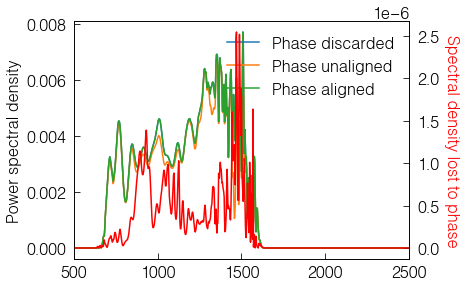

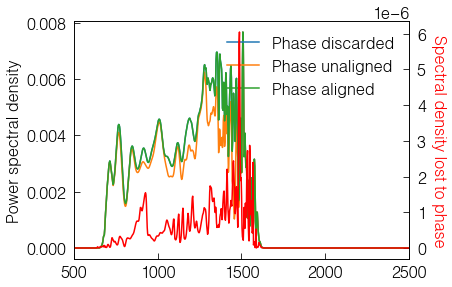

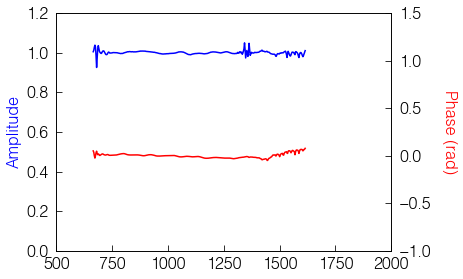

In [1167]:
sample_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1.txt')
sample_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1_BB.txt')
ref_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2.txt')
ref_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2_BB.txt')

reload(sd)
SP = sd.SpectralProcessor(sample_spectra,sample_BB_spectra,
                         ref_spectra,ref_BB_spectra)

f,snorm = SP(envelope_width=1,valid_thresh=.01,
                         optimize_BB=True,
                       optimize_phase=True,
                        view_phase_alignment=True)

plt.figure()
plt.plot(f,np.abs(snorm),color='b')
plt.ylim(0,1.2)
plt.ylabel('Amplitude',color='b')
plt.xlim(500,2000)
plt.twinx()
plt.plot(f,-np.unwrap(np.angle(level_phase(f,snorm,order=1))),color='r')
plt.ylabel('Phase (rad)',rotation=270,color='r',labelpad=25)
plt.ylim(-1,1.5)

Aligning and enveloping spectra...


/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay_FTIR.py:354: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay_FTIR.py:354: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]


Identified calibration factor: 1.0
Processing sample spectra...
Aligning and enveloping spectra...
Aligning phase...


/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay_FTIR.py:354: RuntimeWarning: divide by zero encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay_FTIR.py:354: RuntimeWarning: overflow encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]
/Users/alexandersmcleod/Dropbox (Personal)/python/scandelay/scandelay_FTIR.py:354: RuntimeWarning: invalid value encountered in true_divide
  snorm = (spectrum / spectrum_ref)[where_valid]


Processing reference spectra...
Aligning and enveloping spectra...
Aligning phase...


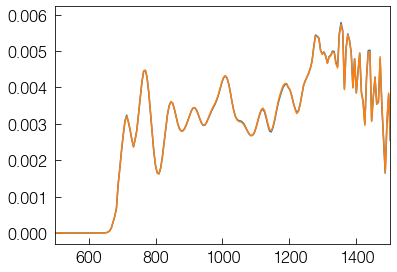

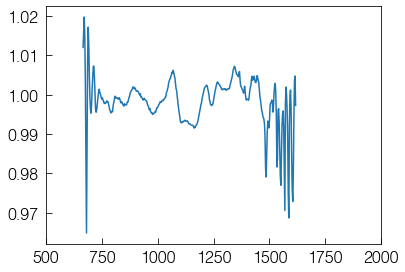

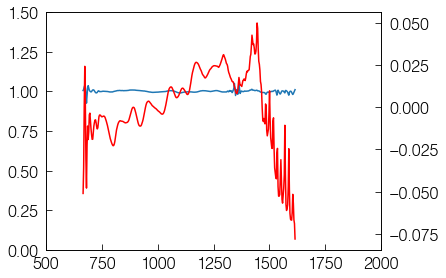

In [11]:
reload(sd)
sample_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1.txt')
sample_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 1_BB.txt')
ref_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2.txt')
ref_BB_spectra=np.loadtxt('Test Data/BB 100% line/BB 100% line spectra 2_BB.txt')

f,s = sd.accumulate_spectra(sample_spectra, apply_envelope=True, expand_envelope=1)
plt.plot(f,s)
f,s = sd.accumulate_spectra(sample_BB_spectra, apply_envelope=True, expand_envelope=1)
plt.plot(f,s)
plt.xlim(500,1500)

plt.figure()
f,sabs,sphase = sd.BB_referenced_spectrum(sample_spectra,sample_BB_spectra,
                          apply_envelope=True, envelope_width=1,
                           optimize_BB=True,
                          optimize_phase=False,abs_only=True,
                           valid_thresh=.01)
plt.plot(f,sabs)
plt.xlim(500,2000)

f,sabs,sphase = sd.normalized_spectrum(sample_spectra, sample_BB_spectra,
                               ref_spectra, ref_BB_spectra,
                               apply_envelope=True, envelope_width=1,
                               optimize_BB=False, optimize_phase=True,
                               valid_thresh=.01)

plt.figure()
plt.plot(f,sabs)
plt.ylim(0,1.5)
plt.xlim(500,2000)
plt.twinx()
plt.plot(f,sphase,color='r')

# What's next?

* We have succesfully phase-aligned sample spectra, and reference spectra, and normalized one to the other
* All-at-once and center-out methods give identical results